<a href="https://colab.research.google.com/github/igormatt0s/modelo-previsao-precos-imoveis-NY/blob/main/Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Lighthouse] Desafio Ciência de Dados 2025-3**





**Seu objetivo é desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema.**

In [1]:
'''
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
'''

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import joblib
from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans

# Importar o algoritmo de classificação
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [3]:
# Carregar o dataset
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTVGzO37qHl48Tv_Zu5X6UUdwTMLFyVNacXiDXXGMDq0PJfrdqPGUIl31isUG9q-HAnPmItzEa1KLvM/pub?gid=423359822&single=true&output=csv')
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,4.075.362,-7.398.377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,4.080.902,-739.419,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,4.068.514,-7.395.976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,4.079.851,-7.394.399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,4.074.767,-73.975,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


## Etapa 1: Análise Exploratória de Dados (EDA)

Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses de negócio relacionadas.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  object 
 7   longitude                      48894 non-null  object 
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [5]:
df.isnull().sum()

,0
id,0
nome,16
host_id,0
host_name,21
bairro_group,0
bairro,0
latitude,0
longitude,0
room_type,0
price,0


In [6]:
# Conversão de tipos de dados
df['latitude'] = df['latitude'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float) # Converter taxa para float
df['longitude'] = df['longitude'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

df['latitude'] = df['latitude'] / 10**(df['latitude'].astype(str).str.len() - 4)
df['longitude'] = df['longitude'] / 10**(df['longitude'].astype(str).str.len() - 5)

df['ultima_review'] = pd.to_datetime(df['ultima_review'], errors='coerce') # Converter datas


In [7]:
# Calcular estatísticas descritivas
quanti = df.drop(columns=['id', 'host_id'])
quanti.describe()

,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842,38842.000000,48894.000000,48894.000000
mean,40.728951,-73.952169,152.720763,7.030085,23.274758,2018-10-04 01:46:50.710055936,1.373251,7.144005,112.776169
min,40.499790,-74.244420,0.000000,1.000000,0.000000,2011-03-28 00:00:00,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,2018-07-08 00:00:00,0.190000,1.000000,0.000000
50%,40.723075,-73.955680,106.000000,3.000000,5.000000,2019-05-19 00:00:00,0.720000,1.000000,45.000000
75%,40.763117,-73.936273,175.000000,5.000000,24.000000,2019-06-23 00:00:00,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,2019-07-08 00:00:00,58.500000,327.000000,365.000000
std,0.054529,0.046157,240.156625,20.510741,44.550991,NaN,1.680453,32.952855,131.618692


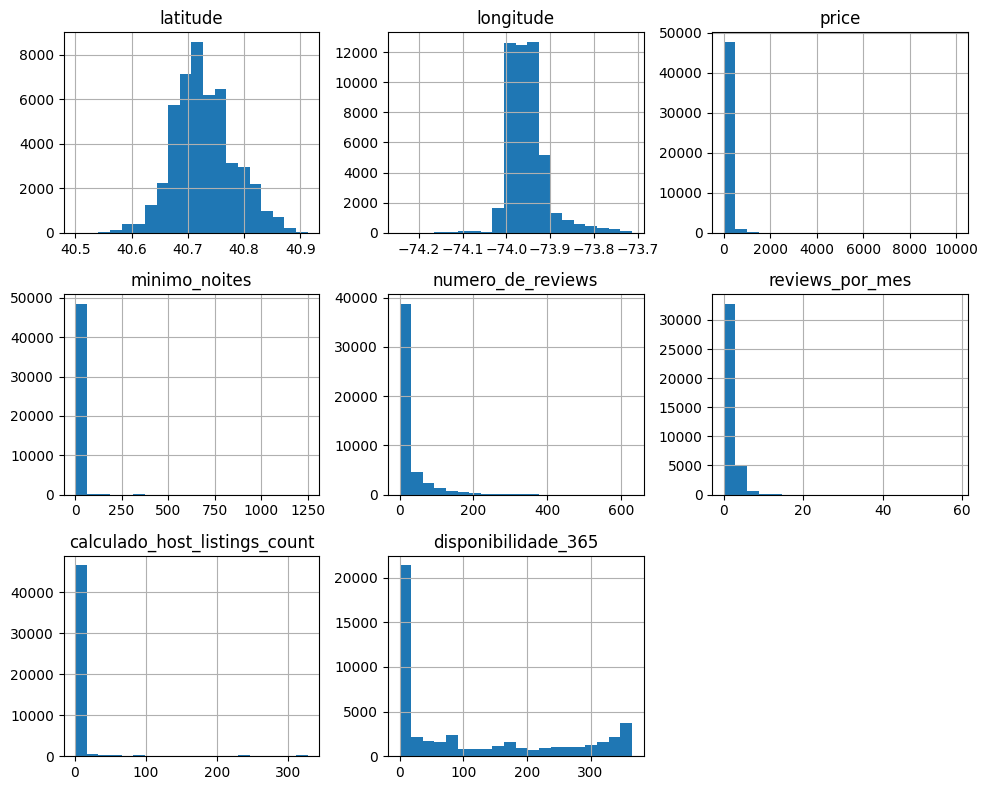

In [8]:
# Distribuição das colunas numéricas
df[['latitude', 'longitude', 'price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']].hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

In [9]:
cols_to_categorical = ['host_name', 'bairro_group', 'bairro', 'room_type']
for col in cols_to_categorical:
    print(col)
    display(df[col].value_counts().reset_index())
    print()

host_name


,host_name,count
0,Michael,417
1,David,403
2,Sonder (NYC),327
3,John,293
4,Alex,279
...,...,...
11447,Rhonycs,1
11448,Brandy-Courtney,1
11449,Shanthony,1
11450,Aurore And Jamila,1



bairro_group


,bairro_group,count
0,Manhattan,21661
1,Brooklyn,20103
2,Queens,5666
3,Bronx,1091
4,Staten Island,373



bairro


,bairro,count
0,Williamsburg,3920
1,Bedford-Stuyvesant,3714
2,Harlem,2658
3,Bushwick,2465
4,Upper West Side,1971
...,...,...
216,Fort Wadsworth,1
217,Richmondtown,1
218,New Dorp,1
219,Rossville,1



room_type


,room_type,count
0,Entire home/apt,25409
1,Private room,22325
2,Shared room,1160


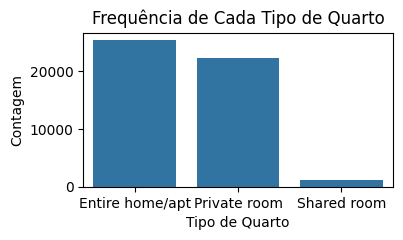

In [10]:
plt.figure(figsize=(4, 2))
sns.countplot(x=df['room_type'], order=df['room_type'].value_counts().index)
plt.xlabel('Tipo de Quarto')
plt.ylabel('Contagem')
plt.title('Frequência de Cada Tipo de Quarto')
plt.show()


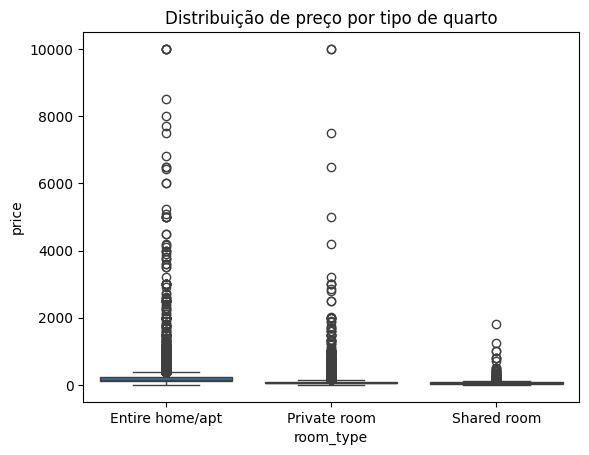

In [11]:
# relação da coluna price com as room_type
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Distribuição de preço por tipo de quarto')
plt.show()

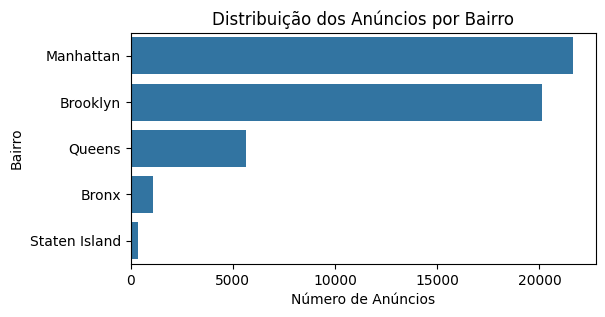

In [12]:
plt.figure(figsize=(6, 3))
sns.countplot(y=df['bairro_group'], order=df['bairro_group'].value_counts().index)
plt.ylabel('Bairro')
plt.xlabel('Número de Anúncios')
plt.title('Distribuição dos Anúncios por Bairro')
plt.show()

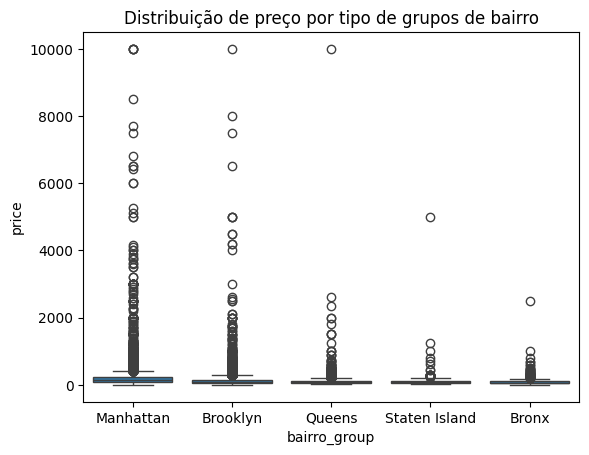

In [13]:
# relação da coluna price com as bairro_group
sns.boxplot(x='bairro_group', y='price', data=df)
plt.title('Distribuição de preço por tipo de grupos de bairro')
plt.show()

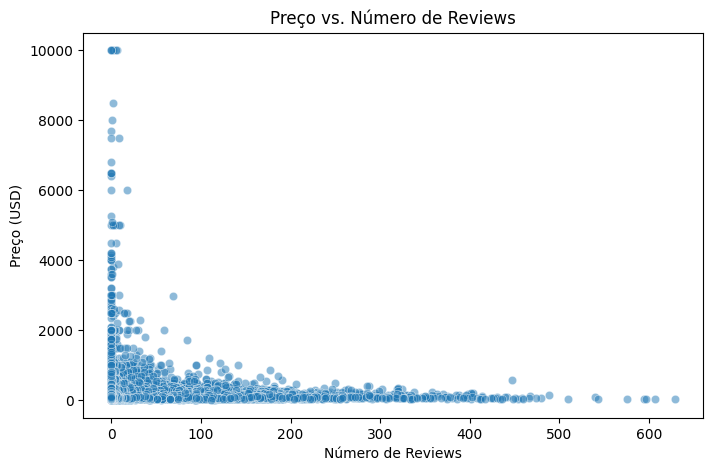

In [14]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='numero_de_reviews', y='price', data=df, alpha=0.5)
plt.xlabel('Número de Reviews')
plt.ylabel('Preço (USD)')
plt.title('Preço vs. Número de Reviews')
plt.show()

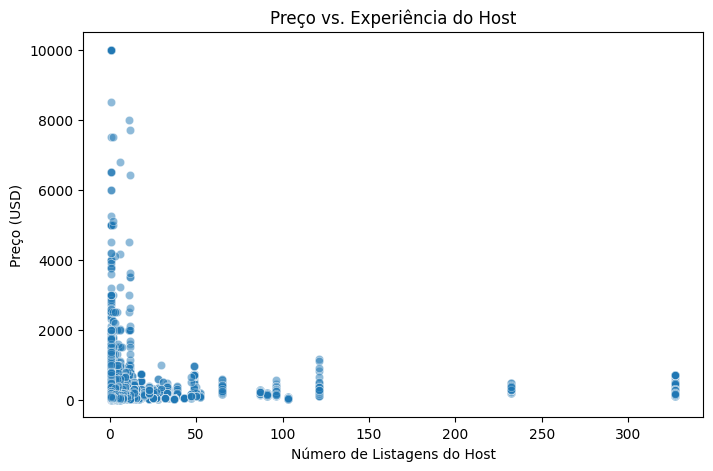

In [15]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='calculado_host_listings_count', y='price', data=df, alpha=0.5)
plt.xlabel('Número de Listagens do Host')
plt.ylabel('Preço (USD)')
plt.title('Preço vs. Experiência do Host')
plt.show()

In [16]:
# Anúncios em bairros mais centrais tendem a ter preços mais altos?
df.groupby('bairro_group')['price'].mean().sort_values(ascending=False).reset_index()

,bairro_group,price
0,Manhattan,196.875814
1,Brooklyn,124.381983
2,Staten Island,114.812332
3,Queens,99.517649
4,Bronx,87.496792


In [17]:
# Quartos inteiros têm preços significativamente mais altos que quartos compartilhados?
df.groupby('room_type')['price'].mean().reset_index()

,room_type,price
0,Entire home/apt,211.794246
1,Private room,89.778320
2,Shared room,70.127586


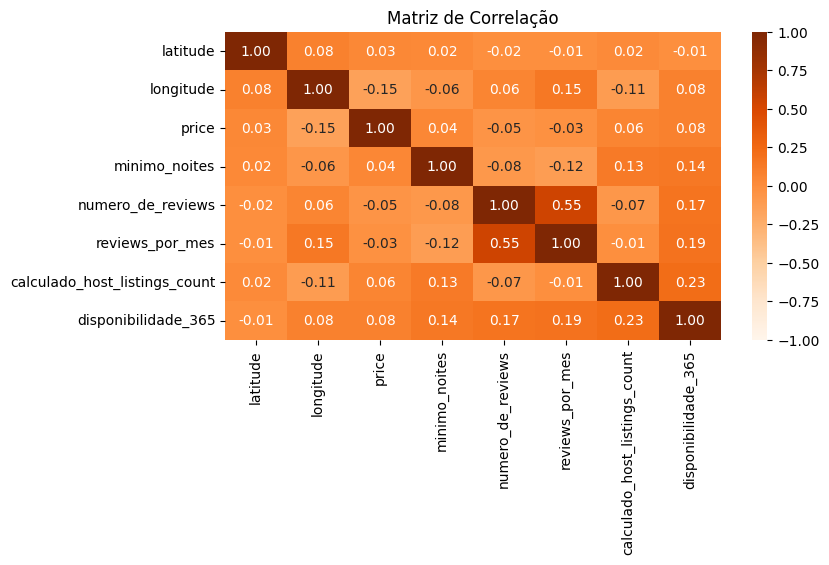

In [18]:
# Matriz de correlação
plt.figure(figsize=(8, 4))
sns.heatmap(df[['latitude', 'longitude', 'price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']].corr(), annot=True, fmt=".2f", cmap="Oranges", vmin=-1, vmax=1)
plt.title("Matriz de Correlação")
plt.show()

###Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

In [19]:
df['disponibilidades_dias'] = df['disponibilidade_365'].replace(0, 1)
(df.groupby('bairro')['price'].mean()/df.groupby('bairro')['disponibilidades_dias'].mean()).sort_values(ascending=False).reset_index(name='razao')

,bairro,razao
0,Woodrow,700.000000
1,"Bay Terrace, Staten Island",102.500000
2,New Dorp,57.000000
3,Sea Gate,7.375810
4,Tribeca,3.868630
...,...,...
216,Corona,0.242306
217,Grant City,0.239945
218,Concord,0.227690
219,Co-op City,0.212912


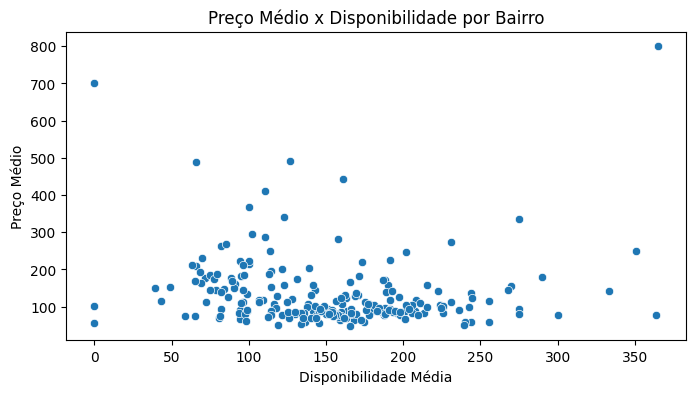

'\nUm bom investimento seria um bairro com preços altos, mas que também tenha baixa\ndisponibilidade, pois isso pode indicar alta taxa de ocupação e alta demanda.\n'

In [20]:
# Identificar os bairros mais rentáveis
# Identificar onde há maior demanda
plt.figure(figsize=(8,4))
sns.scatterplot(x=df.groupby('bairro')['disponibilidade_365'].mean(),
                y=df.groupby('bairro')['price'].mean())
plt.xlabel('Disponibilidade Média')
plt.ylabel('Preço Médio')
plt.title('Preço Médio x Disponibilidade por Bairro')
plt.show()

'''
Um bom investimento seria um bairro com preços altos, mas que também tenha baixa
disponibilidade, pois isso pode indicar alta taxa de ocupação e alta demanda.
'''

###O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

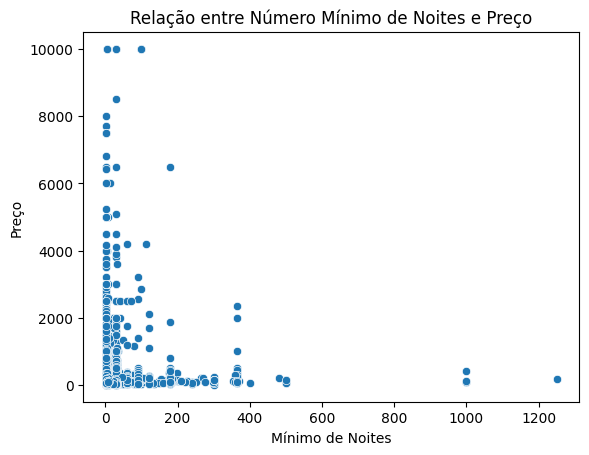

In [21]:
sns.scatterplot(x=df['minimo_noites'], y=df['price'])
plt.xlabel('Mínimo de Noites')
plt.ylabel('Preço')
plt.title('Relação entre Número Mínimo de Noites e Preço')
plt.show()

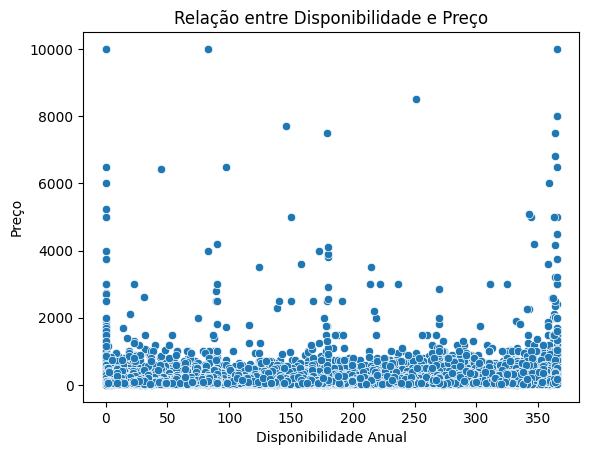

In [22]:
sns.scatterplot(x=df['disponibilidade_365'], y=df['price'])
plt.xlabel('Disponibilidade Anual')
plt.ylabel('Preço')
plt.title('Relação entre Disponibilidade e Preço')
plt.show()

###Existe algum padrão no texto do nome do local para lugares de mais alto valor?

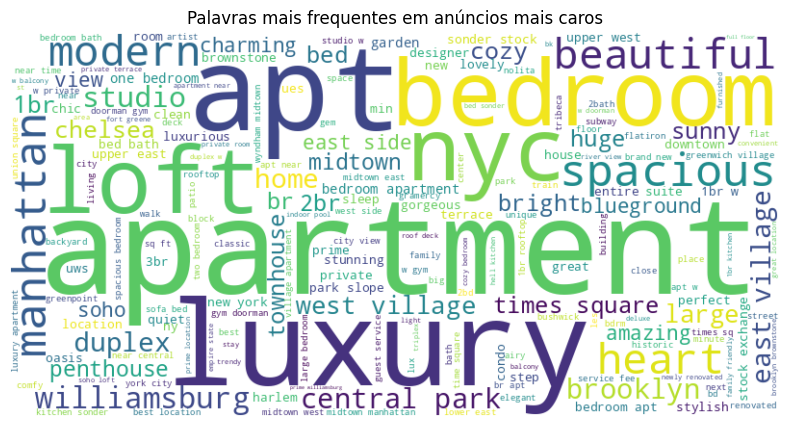

In [23]:
def normalize_text(text):
    text = text.lower()  # Converter para minúsculas
    text = re.sub(r"\s+", " ", text).strip()  # Remover espaços extras
    return text

# Filtrar os 20% anúncios mais caros
top_20_percent = df[df['price'] > df['price'].quantile(0.8)]

# Juntar os nomes dos anúncios mais caros
text = " ".join(top_20_percent['nome'].astype(str).apply(normalize_text))

# Criar nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Palavras mais frequentes em anúncios mais caros")
plt.show()

In [24]:
# Criar lista de palavras dos anúncios mais caros e mais baratos
palavras_caras = " ".join(top_20_percent['nome'].astype(str).apply(normalize_text)).split()
palavras_baratas = " ".join(df[df['price'] < df['price'].quantile(0.2)]['nome'].astype(str).apply(normalize_text)).split()

# Contar palavras mais comuns
contagem_caras = Counter(palavras_caras).most_common(20)
contagem_baratas = Counter(palavras_baratas).most_common(20)

print("Palavras mais comuns em anúncios caros:", contagem_caras)
print("Palavras mais comuns em anúncios baratos:", contagem_baratas)

Palavras mais comuns em anúncios caros: [('in', 2174), ('bedroom', 1103), ('2', 1086), ('apartment', 1015), ('apt', 724), ('the', 721), ('luxury', 693), ('village', 647), ('of', 600), ('|', 597), ('with', 591), ('east', 587), ('loft', 577), ('+', 525), ('1', 523), ('park', 521), ('studio', 520), ('1br', 515), ('spacious', 507), ('west', 491)]
Palavras mais comuns em anúncios baratos: [('room', 3684), ('in', 3351), ('private', 1923), ('bedroom', 1262), ('cozy', 1214), ('to', 957), ('brooklyn', 833), ('apartment', 612), ('and', 608), ('&', 544), ('spacious', 541), ('the', 526), ('manhattan', 518), ('near', 514), ('a', 500), ('with', 498), ('sunny', 494), ('bushwick', 456), ('for', 408), ('from', 362)]


## Etapa 2: Pré-processamento dos Dados

Prepare o dataset para o treinamento do modelo, incluindo:
- Limpeza dos dados: Trate valores ausentes (missing values) e corrija possíveis
inconsistências.
- Feature Engineering: Crie novas variáveis ou transforme as existentes para
melhorar o desempenho do modelo.
- Divisão do Dataset: Separe os dados em conjuntos de treinamento, validação e
teste de forma adequada.

In [25]:
# Substituindo valores ausentes
df.drop(columns=['nome', 'host_name', 'disponibilidades_dias'], inplace=True)

df['reviews_por_mes'].fillna(-1, inplace=True)

df['dias_desde_ultima_review'] = (pd.Timestamp.now() - df['ultima_review']).dt.days.fillna(-1)
df['tem_review'] = df['ultima_review'].notna().astype(int)
df['ultima_review'] = df['ultima_review'].fillna(pd.Timestamp('1900-01-01'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48894 non-null  int64         
 1   host_id                        48894 non-null  int64         
 2   bairro_group                   48894 non-null  object        
 3   bairro                         48894 non-null  object        
 4   latitude                       48894 non-null  float64       
 5   longitude                      48894 non-null  float64       
 6   room_type                      48894 non-null  object        
 7   price                          48894 non-null  int64         
 8   minimo_noites                  48894 non-null  int64         
 9   numero_de_reviews              48894 non-null  int64         
 10  ultima_review                  48894 non-null  datetime64[ns]
 11  reviews_por_mes

<ipython-input-25-9503c6108314>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_por_mes'].fillna(-1, inplace=True)


In [26]:
# Função para tratar outliers com base no IQR
# Definir limite superior (95º percentil)
limite_superior_price = df['price'].quantile(0.95)
df_corrigido = df[df['price'] <= limite_superior_price]
limite_superior_minimo_noites = df['minimo_noites'].quantile(0.95)
df_corrigido = df[df['minimo_noites'] <= limite_superior_minimo_noites]
limite_superior_reviews = df['numero_de_reviews'].quantile(0.95)
df_corrigido = df[df['numero_de_reviews'] <= limite_superior_reviews]
limite_superior_reviews_mes = df['reviews_por_mes'].quantile(0.95)
df_corrigido = df[df['reviews_por_mes'] <= limite_superior_reviews_mes]
limite_superior_host_listings = df['calculado_host_listings_count'].quantile(0.95)
df_corrigido = df[df['calculado_host_listings_count'] <= limite_superior_host_listings]

# Filtrar valores inconsistentes
df_corrigido = df[(df['disponibilidade_365'] >= 0) & (df['disponibilidade_365'] <= 365)]

df_corrigido.iloc[:, 1:].describe()

,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,dias_desde_ultima_review,tem_review
count,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000
mean,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1994-05-05 16:43:31.756043648,0.885340,7.144005,112.776169,1840.389005,0.794412
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,1900-01-01 00:00:00,-1.000000,1.000000,0.000000,-1.000000,0.000000
25%,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,2016-03-24 00:00:00,0.040000,1.000000,0.000000,2044.000000,1.000000
50%,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,2019-01-03 00:00:00,0.370000,1.000000,45.000000,2064.000000,1.000000
75%,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2019-06-19 00:00:00,1.580000,2.000000,227.000000,2286.000000,1.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,2019-07-08 00:00:00,58.500000,327.000000,365.000000,5064.000000,1.000000
std,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,NaN,1.778551,32.952855,131.618692,1006.784412,0.404134


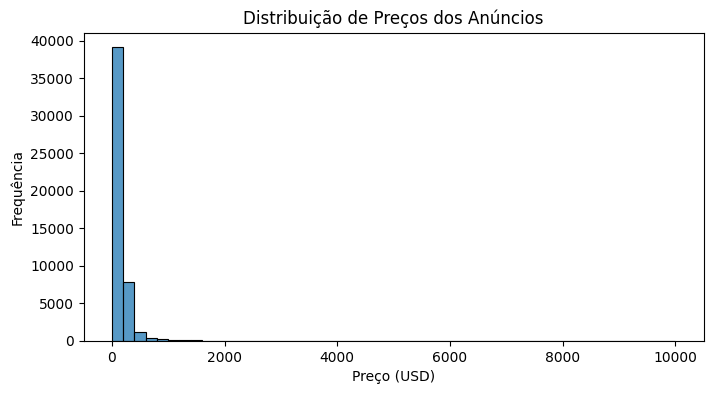

In [27]:
plt.figure(figsize=(8, 4))
sns.histplot(df_corrigido['price'], bins=50)
plt.xlabel('Preço (USD)')
plt.ylabel('Frequência')
plt.title('Distribuição de Preços dos Anúncios')
plt.show()

In [28]:
# Convertendo variáveis categóricas em dummies (one-hot encoding)
df_corrigido = pd.get_dummies(df_corrigido, columns=['bairro_group'], drop_first=True)
df_corrigido = pd.get_dummies(df_corrigido, columns=['room_type'], drop_first=True)

# Calcular a média do preço por bairro
bairro_means = df_corrigido.groupby('bairro')['price'].mean().to_dict()
# Calcular a média do preço por host
host_means = df_corrigido.groupby('host_id')['price'].mean().to_dict()

# Smoothing para evitar overfitting
global_mean = df_corrigido['price'].mean()
smoothing_factor = 10
bairro_counts = df_corrigido['bairro'].value_counts()
host_counts = df_corrigido['host_id'].value_counts()

# Target Encoding com Smoothing
df_corrigido['bairro_encoded'] = df_corrigido['bairro'].map(
    lambda x: (bairro_means[x] * bairro_counts[x] + global_mean * smoothing_factor) / (bairro_counts[x] + smoothing_factor)
)
df_corrigido['host_encoded'] = df_corrigido['host_id'].map(
    lambda x: (host_means[x] * host_counts[x] + global_mean * smoothing_factor) / (host_counts[x] + smoothing_factor)
)

# Frequency Encoding
bairro_freq = df_corrigido['bairro'].value_counts(normalize=True).to_dict()
df_corrigido['bairro_freq'] = df_corrigido['bairro'].map(bairro_freq)
host_freq = df_corrigido['host_id'].value_counts(normalize=True).to_dict()
df_corrigido['host_freq'] = df_corrigido['host_id'].map(host_freq)

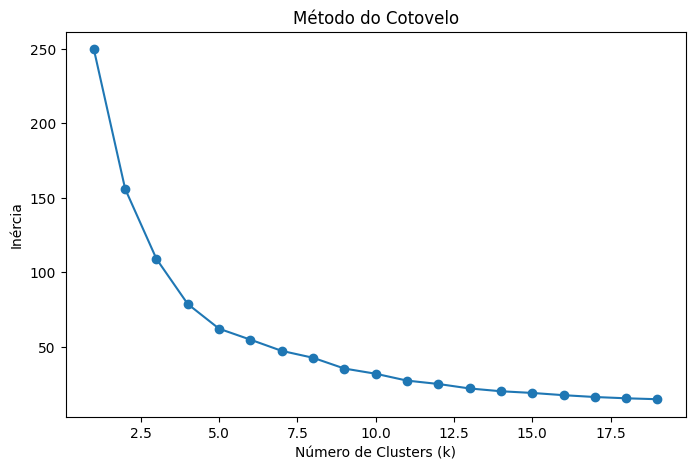

In [29]:
# Dados de latitude e longitude
coords = df_corrigido[['latitude', 'longitude']]

# Lista para armazenar as inércias
inercia = []

# Testar diferentes números de clusters
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inercia.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 20), inercia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

In [30]:
# Feature Engineering
df_corrigido['preco_por_disponibilidade'] = df_corrigido['price'] / (df_corrigido['disponibilidade_365'] + 1)
df_corrigido['preco_por_reviews'] = df_corrigido['price'] / (df_corrigido['numero_de_reviews'] + 1)
df_corrigido['preco_por_minimo_noites'] = df_corrigido['price'] / df_corrigido['minimo_noites']

preco_medio_por_disponibilidade = df_corrigido.groupby(['host_id', 'bairro'])['preco_por_disponibilidade'].mean().reset_index()
preco_medio_por_reviews = df_corrigido.groupby(['host_id', 'bairro', 'tem_review'])['preco_por_reviews'].mean().reset_index()
preco_medio_por_minimo_noites = df_corrigido.groupby(['host_id', 'bairro'])['preco_por_minimo_noites'].mean().reset_index()

# Coordenadas do centro da cidade de Nova York
centro_latitude = 40.7128
centro_longitude = -74.0060

# Calcular distância euclidiana
df_corrigido['distancia_ao_centro'] = np.sqrt(
    (df_corrigido['latitude'] - centro_latitude)**2 + (df_corrigido['longitude'] - centro_longitude)**2
)

# Clusters geográficos
coords = df_corrigido[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)
df_corrigido['regiao_cluster'] = kmeans.fit_predict(coords)
joblib.dump(kmeans, 'kmeans.pkl')

df_corrigido['variação_preco_host'] = df_corrigido.groupby('host_id')['price'].transform('std')
df_corrigido['variação_preco_host'].fillna(0, inplace=True)

variação_media_preco_host = df_corrigido.groupby(['host_id'])['variação_preco_host'].mean().reset_index()

<ipython-input-30-5e832b3ca2cb>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_corrigido['variação_preco_host'].fillna(0, inplace=True)


In [31]:
df_corrigido.drop(columns=['bairro'], inplace=True)
df_corrigido.drop(columns=['host_id'], inplace=True)

df_escalonado = df_corrigido.copy()

# Colunas para normalizar
colunas_para_normalizar = [
    'latitude', 'longitude', 'minimo_noites', 'numero_de_reviews',
    'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365',
    'dias_desde_ultima_review', 'bairro_encoded', 'bairro_freq','host_encoded',
    'host_freq', 'preco_por_disponibilidade', 'preco_por_reviews', 'preco_por_minimo_noites',
    'distancia_ao_centro', 'regiao_cluster', 'variação_preco_host'
]

# Normalização Min-Max
scaler_minmax = MinMaxScaler()
df_escalonado[colunas_para_normalizar] = scaler_minmax.fit_transform(df_escalonado[colunas_para_normalizar])

# Padronização Z-score
scaler_zscore = StandardScaler()
df_escalonado[colunas_para_normalizar] = scaler_zscore.fit_transform(df_escalonado[colunas_para_normalizar])

df_escalonado.iloc[:, 1:].describe()

,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,dias_desde_ultima_review,...,bairro_encoded,host_encoded,bairro_freq,host_freq,preco_por_disponibilidade,preco_por_reviews,preco_por_minimo_noites,distancia_ao_centro,regiao_cluster,variação_preco_host
count,4.889400e+04,4.889400e+04,48894.000000,4.889400e+04,4.889400e+04,48894,4.889400e+04,4.889400e+04,4.889400e+04,4.889400e+04,...,4.889400e+04,4.889400e+04,4.889400e+04,4.889400e+04,48894.000000,48894.000000,4.889400e+04,4.889400e+04,4.889400e+04,4.889400e+04
mean,-7.986957e-16,9.277426e-16,152.720763,3.138979e-17,6.510475e-17,1994-05-05 16:43:31.756043648,8.603127e-17,3.720271e-17,1.209088e-16,9.300678e-17,...,-1.743877e-17,7.208025e-17,1.232340e-16,3.720271e-17,0.000000,0.000000,3.952788e-17,1.255592e-16,6.045441e-17,4.650339e-18
min,-4.202557e+00,-6.331717e+00,0.000000,-2.939995e-01,-5.224350e-01,1900-01-01 00:00:00,-1.060054e+00,-1.864503e-01,-8.568488e-01,-1.828999e+00,...,-1.413331e+00,-2.084828e+00,-1.204230e+00,-1.864471e-01,-0.363022,-0.317880,-4.452014e-01,-1.618435e+00,-1.300398e+00,-1.967121e-01
25%,-7.124771e-01,-6.694767e-01,69.000000,-2.939995e-01,-4.999885e-01,2016-03-24 00:00:00,-4.753020e-01,-1.864503e-01,-8.568488e-01,2.022410e-01,...,-7.652360e-01,-2.226721e-01,-8.931712e-01,-1.864471e-01,-0.358674,-0.295475,-3.183139e-01,-6.540152e-01,-1.300398e+00,-1.967121e-01
50%,-1.077512e-01,-7.606269e-02,106.000000,-1.964886e-01,-4.102029e-01,2019-01-03 00:00:00,-2.897558e-01,-1.864503e-01,-5.149486e-01,2.221064e-01,...,-1.602324e-01,-1.285406e-01,-3.164006e-01,-1.864471e-01,-0.342678,-0.223261,-1.628768e-01,-1.830995e-01,1.363133e-01,-1.967121e-01
75%,6.265851e-01,3.444076e-01,175.000000,-9.897771e-02,1.627909e-02,2019-06-19 00:00:00,3.905801e-01,-1.561036e-01,8.678479e-01,4.426127e-01,...,5.941669e-01,2.935674e-02,7.559951e-01,-1.561004e-01,0.166025,-0.001582,7.186503e-02,4.665437e-01,8.546689e-01,-1.207132e-01
max,3.376369e+00,5.181902e+00,10000.000000,6.060155e+01,1.359636e+01,2019-07-08 00:00:00,3.239448e+01,9.706572e+00,1.916342e+00,3.201921e+00,...,5.360467e+00,3.316556e+01,1.913514e+00,9.706574e+00,70.176561,53.750191,5.030978e+01,5.034106e+00,1.573025e+00,5.989669e+01
std,1.000010e+00,1.000010e+00,240.156625,1.000010e+00,1.000010e+00,NaN,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,...,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010,1.000010,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00


In [32]:
df_escalonado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48894 non-null  int64         
 1   latitude                       48894 non-null  float64       
 2   longitude                      48894 non-null  float64       
 3   price                          48894 non-null  int64         
 4   minimo_noites                  48894 non-null  float64       
 5   numero_de_reviews              48894 non-null  float64       
 6   ultima_review                  48894 non-null  datetime64[ns]
 7   reviews_por_mes                48894 non-null  float64       
 8   calculado_host_listings_count  48894 non-null  float64       
 9   disponibilidade_365            48894 non-null  float64       
 10  dias_desde_ultima_review       48894 non-null  float64       
 11  tem_review     

In [33]:
# Separando os dados em features (X) e target (y)
X = df_escalonado.drop(columns=['price', 'id', 'ultima_review'])
y = df_escalonado['price']

# Dividindo o dataset em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividindo o conjunto de treino para validação (80% treino, 20% validação)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Divisão concluída. Tamanho dos conjuntos:")
print(f"Treinamento: {X_train.shape[0]} registros")
print(f"Validação: {X_val.shape[0]} registros")
print(f"Teste: {X_test.shape[0]} registros")

Divisão concluída. Tamanho dos conjuntos:
Treinamento: 27380 registros
Validação: 6845 registros
Teste: 14669 registros


In [34]:
# Definir colunas numéricas e categóricas
colunas_numericas = ["latitude", "longitude", "minimo_noites", "numero_de_reviews",
                     "reviews_por_mes", "calculado_host_listings_count", "disponibilidade_365",
                     "dias_desde_ultima_review", "bairro_encoded", "host_encoded", "bairro_freq",
                     "host_freq", "preco_por_disponibilidade", "preco_por_reviews", "preco_por_minimo_noites",
                     "distancia_ao_centro", "regiao_cluster", "variação_preco_host"]

# Criando pipeline de normalização e padronização
pipeline_preprocessamento = Pipeline([
    ("scaler_minmax", MinMaxScaler()),
    ("scaler_zscore", StandardScaler())
])

# Aplicar normalização e padronização ao conjunto de treino
X_train[colunas_para_normalizar] = pipeline_preprocessamento.fit_transform(X_train[colunas_para_normalizar])

# Salvar pipeline de pré-processamento
joblib.dump(pipeline_preprocessamento, "preprocessor.pkl")

['preprocessor.pkl']

## Etapa 3: Modelo de Regressão

Escolha do modelo de regressão com base nas características do problema e do dataset. Durante essa etapa, será necessário avaliar a importância das variáveis utilizadas no modelo, destacando aquelas que mais contribuem para a classificação.

In [35]:
# Definir os modelos de classificação
modelos = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

### Avaliação do melhor modelo 1

In [36]:
# Validação cruzada (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar cada modelo
results = {}
print("\nResultados da Validação Cruzada:")
for name, modelo in modelos.items():
    try:
      cv_scores = cross_val_score(modelo, X_train, y_train, cv=kf, scoring="neg_root_mean_squared_error")
      results[name] = -np.mean(cv_scores)  # O sklearn retorna valores negativos para minimizar, então inverte-se o sinal
      print(f"{name}: RMSE médio = {results[name]:.2f}")
    except:
      print(f"{name}: Erro ao calcular RMSE médio")


Resultados da Validação Cruzada:
Linear Regression: RMSE médio = 123.04
Decision Tree: RMSE médio = 98.22
Random Forest: RMSE médio = 67.01
Gradient Boosting: RMSE médio = 63.11
SVR: RMSE médio = 233.40
XGBoost: RMSE médio = 94.82


### Avaliação do melhor modelo 2

In [37]:
# Iterar sobre os modelos
for nome, modelo in modelos.items():
    print(f"Modelo: {nome}")

    # Medir o tempo de treinamento
    start_time = time.time()
    # Treinar o modelo no conjunto de treino
    modelo.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"  Tempo de treinamento: {training_time:.4f} segundos")

    # Fazer previsões no conjunto de validação
    y_val_pred = modelo.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f"RMSE no conjunto de validação: {val_rmse:.2f}")

    # Fazer previsões no conjunto de teste
    start_time = time.time()
    y_test_pred = modelo.predict(X_test)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Tempo de predição para {len(X_test)} amostras: {inference_time:.4f} segundos")

    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    print(f"RMSE no conjunto de teste: {test_rmse:.2f}")
    print(f"MAE no conjunto de teste: {test_mae:.2f}")
    print(f"R² no conjunto de teste: {test_r2:.2f}")

    print("-" * 30)

Modelo: Linear Regression
  Tempo de treinamento: 0.0240 segundos
RMSE no conjunto de validação: 103.51
Tempo de predição para 14669 amostras: 0.0062 segundos
RMSE no conjunto de teste: 104.66
MAE no conjunto de teste: 40.02
R² no conjunto de teste: 0.76
------------------------------
Modelo: Decision Tree
  Tempo de treinamento: 0.6118 segundos
RMSE no conjunto de validação: 99.33
Tempo de predição para 14669 amostras: 0.0058 segundos
RMSE no conjunto de teste: 103.80
MAE no conjunto de teste: 33.85
R² no conjunto de teste: 0.77
------------------------------
Modelo: Random Forest
  Tempo de treinamento: 52.5429 segundos
RMSE no conjunto de validação: 81.51
Tempo de predição para 14669 amostras: 0.5772 segundos
RMSE no conjunto de teste: 81.06
MAE no conjunto de teste: 28.91
R² no conjunto de teste: 0.86
------------------------------
Modelo: Gradient Boosting
  Tempo de treinamento: 16.5717 segundos
RMSE no conjunto de validação: 50.74
Tempo de predição para 14669 amostras: 0.0243 se

###Ecolhendo os melhores modelos

In [38]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir o espaço de busca para os hiperparâmetros
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Número de combinações testadas
    scoring='neg_root_mean_squared_error',
    cv=3,  # Validação cruzada de 3 folds
    verbose=2,
    n_jobs=-1,  # Paralelizar a busca
    random_state=42
)

# Rodar a busca de hiperparâmetros
random_search.fit(X_train, y_train)

# Melhor combinação encontrada
best_params = random_search.best_params_
print("\nMelhores Hiperparâmetros:", best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Melhores Hiperparâmetros: {'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}


In [39]:
# Treinar modelo final com early stopping
final_xgb = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42, eval_metric="rmse", early_stopping_rounds=10)

# Medir o tempo de treinamento
start_time = time.time()
# Treinar o modelo final no conjunto de treino
final_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)
training_time = time.time() - start_time
print(f"\nTempo de treinamento final: {training_time:.2f} segundos")

# Fazer previsões no conjunto de validação
y_val_pred = final_xgb.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE no conjunto de validação: {val_rmse:.2f}")

# Avaliar no conjunto de teste
start_time = time.time()
y_test_pred = final_xgb.predict(X_test)
inference_time = time.time() - start_time
print(f"Tempo de predição para {len(X_test)} amostras: {inference_time:.4f} segundos")
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nDesempenho no Conjunto de Teste:")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"R²: {test_r2:.2f}")

[0]	validation_0-rmse:226.45197
[1]	validation_0-rmse:219.42190
[2]	validation_0-rmse:213.23612
[3]	validation_0-rmse:207.23731
[4]	validation_0-rmse:201.48936
[5]	validation_0-rmse:196.28023
[6]	validation_0-rmse:192.16157
[7]	validation_0-rmse:187.70897
[8]	validation_0-rmse:184.18943
[9]	validation_0-rmse:180.22872
[10]	validation_0-rmse:176.68654
[11]	validation_0-rmse:173.79102
[12]	validation_0-rmse:169.88759
[13]	validation_0-rmse:167.00664
[14]	validation_0-rmse:164.42141
[15]	validation_0-rmse:162.01331
[16]	validation_0-rmse:158.68411
[17]	validation_0-rmse:156.61894
[18]	validation_0-rmse:154.02218
[19]	validation_0-rmse:151.32343
[20]	validation_0-rmse:149.05370
[21]	validation_0-rmse:147.06689
[22]	validation_0-rmse:146.20860
[23]	validation_0-rmse:144.54098
[24]	validation_0-rmse:142.17969
[25]	validation_0-rmse:141.05765
[26]	validation_0-rmse:138.48775
[27]	validation_0-rmse:137.70689
[28]	validation_0-rmse:136.18340
[29]	validation_0-rmse:135.31687
[30]	validation_0-rm

In [40]:
# Criar o modelo base
gbr = GradientBoostingRegressor(random_state=42)

# Definir o espaço de busca para os hiperparâmetros
param_grid = {
    'n_estimators': [100, 300, 500, 1000],  # Número de árvores
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Taxa de aprendizado
    'max_depth': [3, 5, 7, 10],  # Profundidade máxima das árvores
    'subsample': [0.6, 0.8, 1.0],  # Fração das amostras usadas em cada árvore
    'min_samples_split': [2, 5, 10],  # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 3, 5, 10],  # Mínimo de amostras em cada folha
    'max_features': ['sqrt', 'log2', None]  # Máximo de features por árvore
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_grid,
    n_iter=20,  # Número de combinações testadas (ajustável)
    scoring='neg_root_mean_squared_error',
    cv=3,  # Validação cruzada de 3 folds
    verbose=2,
    n_jobs=-1,  # Paralelizar a busca
    random_state=42
)

# Rodar a busca de hiperparâmetros
random_search.fit(X_train, y_train)

# Melhor combinação encontrada
best_params = random_search.best_params_
print("\nMelhores Hiperparâmetros:", best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Melhores Hiperparâmetros: {'subsample': 0.8, 'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.2}


In [42]:
# Treinar modelo final com os melhores hiperparâmetros
final_gbr = GradientBoostingRegressor(**best_params, random_state=42)

# Medir o tempo de treinamento
start_time = time.time()
final_gbr.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"\nTempo de treinamento final: {training_time:.2f} segundos")

# Fazer previsões no conjunto de validação
y_val_pred = final_gbr.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE no conjunto de validação: {val_rmse:.2f}")

# Avaliar no conjunto de teste
start_time = time.time()
y_test_pred = final_gbr.predict(X_test)
inference_time = time.time() - start_time
print(f"Tempo de predição para {len(X_test)} amostras: {inference_time:.4f} segundos")

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nDesempenho no Conjunto de Teste:")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"R²: {test_r2:.2f}")


Tempo de treinamento final: 98.89 segundos
RMSE no conjunto de validação: 49.15
Tempo de predição para 14669 amostras: 0.2724 segundos

Desempenho no Conjunto de Teste:
RMSE: 48.35
MAE: 21.78
R²: 0.95


In [43]:
# Salvando o Modelo
joblib.dump(final_xgb, 'modelo_xgb.pkl')

['modelo_xgb.pkl']

##Etapa 4: Novo apartamento a ser precificado

In [44]:
# Calcular a média do preço por bairro
print(bairro_means)
# Calcular a média do preço por host
print(host_means)
# média de preço total
print(global_mean)

{'Allerton': 87.5952380952381, 'Arden Heights': 67.25, 'Arrochar': 115.0, 'Arverne': 171.7792207792208, 'Astoria': 117.18777777777778, 'Bath Beach': 81.76470588235294, 'Battery Park City': 367.5571428571429, 'Bay Ridge': 144.43262411347519, 'Bay Terrace': 142.0, 'Bay Terrace, Staten Island': 102.5, 'Baychester': 75.42857142857143, 'Bayside': 157.94871794871796, 'Bayswater': 87.47058823529412, 'Bedford-Stuyvesant': 107.67824448034465, 'Belle Harbor': 171.5, 'Bellerose': 99.35714285714286, 'Belmont': 77.125, 'Bensonhurst': 75.78666666666666, 'Bergen Beach': 106.7, 'Boerum Hill': 176.135593220339, 'Borough Park': 63.06617647058823, 'Breezy Point': 213.33333333333334, 'Briarwood': 105.875, 'Brighton Beach': 131.93333333333334, 'Bronxdale': 57.10526315789474, 'Brooklyn Heights': 209.06493506493507, 'Brownsville': 76.45901639344262, "Bull's Head": 47.333333333333336, 'Bushwick': 84.80040567951319, 'Cambria Heights': 81.73076923076923, 'Canarsie': 104.36734693877551, 'Carroll Gardens': 175.91

In [45]:
bairro_counts.reset_index()

,bairro,count
0,Williamsburg,3920
1,Bedford-Stuyvesant,3714
2,Harlem,2658
3,Bushwick,2465
4,Upper West Side,1971
...,...,...
216,Fort Wadsworth,1
217,Richmondtown,1
218,New Dorp,1
219,Rossville,1


In [46]:
host_counts.reset_index()

,host_id,count
0,219517861,327
1,107434423,232
2,30283594,121
3,137358866,103
4,12243051,96
...,...,...
37452,23727216,1
37453,89211125,1
37454,19928013,1
37455,1017772,1


In [47]:
print(bairro_freq)
print(host_freq)

{'Williamsburg': 0.08017343641346586, 'Bedford-Stuyvesant': 0.07596024052030924, 'Harlem': 0.054362498466069456, 'Bushwick': 0.05041518386714116, 'Upper West Side': 0.040311694686464596, "Hell's Kitchen": 0.040045813392236264, 'East Village': 0.03789831063116129, 'Upper East Side': 0.036773428232502965, 'Crown Heights': 0.031987564936393015, 'Midtown': 0.031598969198674685, 'East Harlem': 0.022845338896388106, 'Greenpoint': 0.02280443408189144, 'Chelsea': 0.022763529267394774, 'Lower East Side': 0.01863214300323148, 'Astoria': 0.018407166523499816, 'Washington Heights': 0.018386714116251483, 'West Village': 0.015707448766719843, 'Financial District': 0.015216590992759849, 'Flatbush': 0.012700944901214872, 'Clinton Hill': 0.01169877694604655, 'Long Island City': 0.01098294269235489, 'Prospect-Lefferts Gardens': 0.010942037877858224, 'Park Slope': 0.010348918067656563, 'East Flatbush': 0.010226203624166564, 'Fort Greene': 0.0100012271444349, 'Murray Hill': 0.009919417515441568, 'Kips Bay

In [51]:
novo_apartamento = pd.DataFrame([{
    'id': 2595,
    'host_id': 2845,
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}])

# Aplicar transformações de pré-processamento
if 'ultima_review' not in novo_apartamento.columns:
    novo_apartamento['dias_desde_ultima_review'] = -1
    novo_apartamento['tem_review'] = 0
    novo_apartamento['ultima_review'] = pd.Timestamp('1900-01-01')
else:
    novo_apartamento['dias_desde_ultima_review'] = (pd.Timestamp.now() - novo_apartamento['ultima_review']).dt.days
    novo_apartamento['tem_review'] = 1

# Convertendo variáveis categóricas em dummies (one-hot encoding)
novo_apartamento['bairro_group_Brooklyn'] = 0
novo_apartamento['bairro_group_Manhattan'] = 0
novo_apartamento['bairro_group_Queens'] = 0
novo_apartamento['bairro_group_Staten Island'] = 0
if (novo_apartamento['bairro_group'].values[0] == 'Brooklyn'):
    novo_apartamento['bairro_group_Brooklyn'] = 1
elif (novo_apartamento['bairro_group'].values[0] == 'Manhattan'):
    novo_apartamento['bairro_group_Manhattan'] = 1
elif (novo_apartamento['bairro_group'].values[0] == 'Queens'):
    novo_apartamento['bairro_group_Queens'] = 1
elif (novo_apartamento['bairro_group'].values[0] == 'Staten Island'):
    novo_apartamento['bairro_group_Staten Island'] = 1

novo_apartamento['room_type_Private room'] = 0
novo_apartamento['room_type_Shared room'] = 0
if (novo_apartamento['room_type'].values[0] == 'Private room'):
    novo_apartamento['room_type_Private room'] = 1
elif (novo_apartamento['room_type'].values[0] == 'Shared room'):
    novo_apartamento['room_type_Shared room'] = 1

# Smoothing para evitar overfitting
smoothing_factor = 10

# Target Encoding com Smoothing
novo_apartamento['bairro_encoded'] = (bairro_means[novo_apartamento['bairro'].values[0]] * bairro_counts[novo_apartamento['bairro'].values[0]] + global_mean * smoothing_factor) / (bairro_counts[novo_apartamento['bairro'].values[0]] + smoothing_factor)
novo_apartamento['host_encoded'] = (host_means[novo_apartamento['host_id'].values[0]] * host_counts[novo_apartamento['host_id'].values[0]] + global_mean * smoothing_factor) / (host_counts[novo_apartamento['host_id'].values[0]] + smoothing_factor)

# Frequency Encoding
novo_apartamento['bairro_freq'] = bairro_freq[novo_apartamento['bairro'].values[0]]
novo_apartamento['host_freq'] = host_freq[novo_apartamento['host_id'].values[0]]

novo_apartamento['preco_por_disponibilidade'] = preco_medio_por_disponibilidade[(preco_medio_por_disponibilidade['host_id'] == novo_apartamento['host_id'].values[0]) & (preco_medio_por_disponibilidade['bairro'] == novo_apartamento['bairro'].values[0])]['preco_por_disponibilidade'].values[0]
novo_apartamento['preco_por_reviews'] = preco_medio_por_reviews[(preco_medio_por_reviews['host_id'] == novo_apartamento['host_id'].values[0]) & (preco_medio_por_reviews['bairro'] == novo_apartamento['bairro'].values[0])]['preco_por_reviews'].values[0]
novo_apartamento['preco_por_minimo_noites'] = preco_medio_por_minimo_noites[(preco_medio_por_minimo_noites['host_id'] == novo_apartamento['host_id'].values[0]) & (preco_medio_por_minimo_noites['bairro'] == novo_apartamento['bairro'].values[0])]['preco_por_minimo_noites'].values[0]

# Coordenadas do centro da cidade de Nova York
centro_latitude = 40.7128
centro_longitude = -74.0060

# Calcular distância euclidiana
novo_apartamento['distancia_ao_centro'] = np.sqrt(
    (novo_apartamento['latitude'] - centro_latitude)**2 + (novo_apartamento['longitude'] - centro_longitude)**2
)

# Clusters geográficos usando o mesmo modelo KMeans treinado anteriormente
kmeans_trained = joblib.load("kmeans.pkl")
novo_apartamento['regiao_cluster'] = kmeans_trained.predict(novo_apartamento[['latitude', 'longitude']])

novo_apartamento['variação_preco_host'] = variação_media_preco_host[variação_media_preco_host['host_id'] == novo_apartamento['host_id'].values[0]]['variação_preco_host'].values[0]

novo_apartamento.drop(columns=['id', 'bairro_group', 'room_type', 'bairro', 'host_id'], inplace=True)

In [52]:
# Carregar pré-processador salvo
pipeline_preprocessamento = joblib.load("preprocessor.pkl")

# Pegar os nomes das colunas usadas no treinamento
colunas_treinadas = pipeline_preprocessamento.feature_names_in_

# Manter apenas as colunas que estavam no treinamento
novo_apartamento_alinhado = novo_apartamento[colunas_treinadas]

# Transformar os dados corretamente
novo_apartamento_encoded = pipeline_preprocessamento.transform(novo_apartamento_alinhado)

novo_apartamento_encoded = pd.DataFrame(novo_apartamento_encoded)
colunas_faltando = set(novo_apartamento.columns) - set(novo_apartamento_encoded.columns)
for coluna in colunas_faltando:
    novo_apartamento_encoded[coluna] = novo_apartamento[coluna]
novo_apartamento_encoded = novo_apartamento_encoded[X.columns]
# Carregar o modelo salvo
final_modelo = joblib.load('modelo_xgb.pkl')

# Fazer a previsão
start_time = time.time()
preco_previsto = final_modelo.predict(novo_apartamento_encoded)
inference_time = time.time() - start_time
print(f"Tempo de predição: {inference_time:.4f} segundos")

# Exibir o resultado
print(f"Preço previsto para o apartamento: ${preco_previsto[0]:.2f}")

Tempo de predição: 0.0156 segundos
Preço previsto para o apartamento: $8283.07
